In [5]:
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as optimize
import math

Gaussian Fit
Mean: 3.2986577084842326 +/- 0.1081610918231245
Std: 1.757068691812919 +/- 0.11378480812451207
--------------------------------------------------
Poisson Fit
Mean: 3.559405400651449 +/- 0.09202107914848014
Gaussian Fit
Mean: 3.3740297575144833 +/- 0.08857268322554021
Std: 1.747009143188857 +/- 0.09256468509133622
--------------------------------------------------
Poisson Fit
Mean: 3.633753038331707 +/- 0.08667048324875462
Gaussian Fit
Mean: 3.4626580580931092 +/- 0.06697902867187838
Std: 1.7041991761789623 +/- 0.06925610858866842
--------------------------------------------------
Poisson Fit
Mean: 3.7055110492143775 +/- 0.10502686886577635
Gaussian Fit
Mean: 9.654951861252206 +/- 0.08254154019753183
Std: 3.0424046360938757 +/- 0.08312565928054116
--------------------------------------------------
Poisson Fit
Mean: 9.904707889373126 +/- 0.0687702998610736


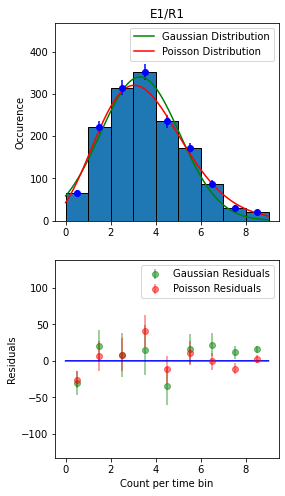

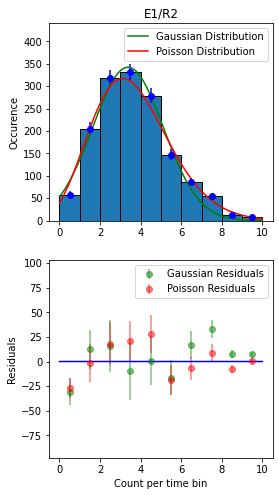

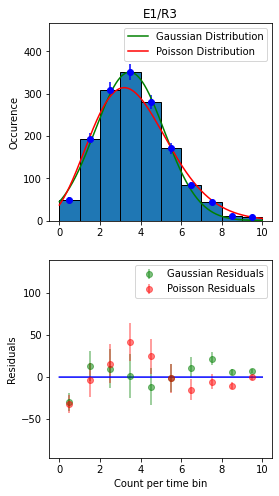

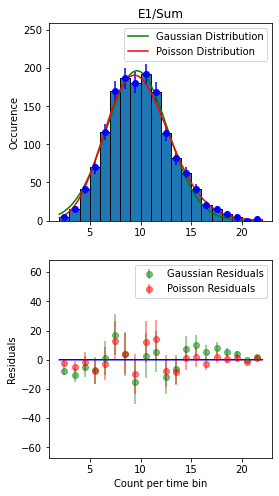

In [6]:
#Here I define the function we will do the fits with
#The A is going to be fixed to the norm of the histogram since the area under each of these functions is 1 by default
def Gaussian(x, mean, std,A):
    return A*(1/(std*(2*np.pi)**0.5))*np.exp(-(x-mean)**2/(2* std**2))
def Poisson(x,mu,A):
    return A*(mu**x/scipy.special.factorial(x)) * np.exp(-mu)
#Here I create variation of the functions that support the uncertainties module. This will be used later
def uGaussian(x, mean, std, A):
    return A*(1/(std*(2*np.pi)**0.5))*unumpy.exp(-(x-mean)**2/(2* std**2))
def uPoisson(x,mu, A):
    return A*(mu**x/scipy.special.factorial(x)) * unumpy.exp(-mu)

#Simply importing all the run
E1 = []
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(1), skip_header=1))
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(3), skip_header=1))
E1.append(np.genfromtxt("E1.csv", delimiter=",", usecols=(5), skip_header=1))
#Doing the horizontal sum of all the runs
E1_sum=E1[0]+E1[1]+E1[2]
E1.append(E1_sum)

#Initialize a variable that keeps track the run indice at which we are going to be
j=0
list_run_num=['R1','R2','R3','Sum']

E1gaverage=[]
E1paverage=[]

#Does the entire process for each run + the horizontal sum
for x in E1:

    #Gets the title of the current run and increase the run indice by 1
    run_num=list_run_num[j]
    j=j+1

    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    
    #Create an histogram with bins of size 1 covering all our data. Note that the density is set to false, this is why A is necessary in the function above
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))

    #Changes the x variable that is now useless to an array of the center points of each bins
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))

    #The errorbar on each bin is (according to google) the squareroot of the count
    nerr=n**0.5
    plt.errorbar(x,n,yerr=nerr,fmt='ob')

    #The norm (The area of the histogram) is calculated by doing the sum of all the counts
    norm = sum(n)

    #Does the Gaussian fit. Note that the bounds limit the A parameter to the norm
    #p0 is really important here since the function is really sensible and having the wrong initial guess will screw up the fit.
    #Also note that in some cases the sigma wasn't working properly so I removed it. I don't know why but it's not that impactful anyway
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[6,5,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    #Stores the parameters and their error in variable that will be used later
    gpopt=popt
    gperr=perr
    
    #Does the Poisson fit. Same info as the Gaussian fit above
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[6,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr

    if(j<4):
        E1gaverage.append(unc.ufloat(gpopt[0],gperr[0]))
        E1paverage.append(unc.ufloat(ppopt[0],pperr[0]))

    #Creates a new variable named xs(x smooth) which will be only used to clearly draw the fits 
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')

    #Here I calculate the point (with it's error, so I use the uGaussian) 
    #   for the center point of each bin this is used to calculate the residuals of each bins 
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))

    #Cleaning the graph
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E1/'+run_num)

    #RESIDUALS
    plt.subplot(2,1,2)

    #Creates an array of ufloat for n (compiles the value of each bin with it's error)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))

    #Plot the error bar and an horizontal line at y=0
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')

    #Cleaning the graph
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E1/'+run_num)

Gaussian Fit
Mean: 31.670954955031316 +/- 0.44635396743415195
Std: 5.435733228002524 +/- 0.45792830488676023
--------------------------------------------------
Poisson Fit
Mean: 31.878962675632103 +/- 0.4635509487015774
Gaussian Fit
Mean: 32.09390656721965 +/- 0.5520348054903699
Std: 5.456977765176654 +/- 0.5584039856839561
--------------------------------------------------
Poisson Fit
Mean: 32.37624389318487 +/- 0.5731195096753108
Gaussian Fit
Mean: 31.604302459392247 +/- 0.6964153837454442
Std: 6.058371855816186 +/- 0.7406570292808354
--------------------------------------------------
Poisson Fit
Mean: 31.94211251459437 +/- 0.6249296478140071
Gaussian Fit
Mean: 96.05917058096003 +/- 1.0047437351390103
Std: 10.12846689983345 +/- 1.0698548739330616
--------------------------------------------------
Poisson Fit
Mean: 96.37136720465882 +/- 0.9504377931914523


C:\Users\cadot\AppData\Local\Temp/ipykernel_23580/2749659550.py:6: RuntimeWarning: overflow encountered in power
  return A*(mu**x/scipy.special.factorial(x)) * np.exp(-mu)
C:\Users\cadot\AppData\Local\Temp/ipykernel_23580/2749659550.py:6: RuntimeWarning: invalid value encountered in multiply
  return A*(mu**x/scipy.special.factorial(x)) * np.exp(-mu)


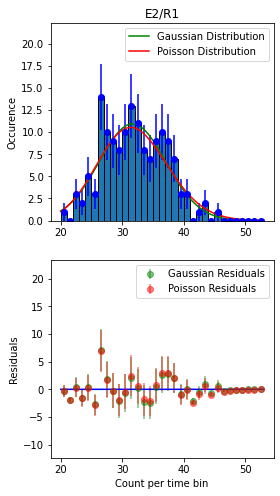

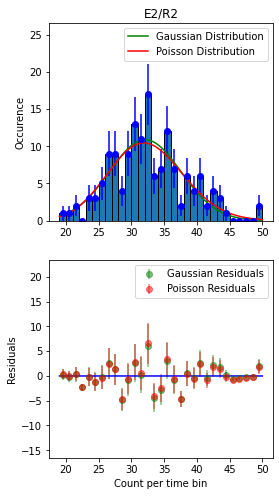

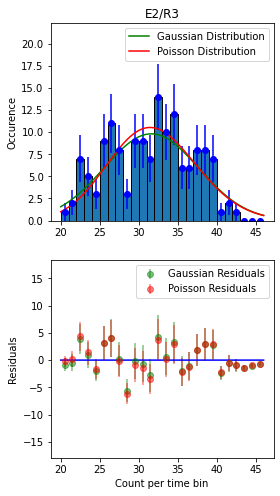

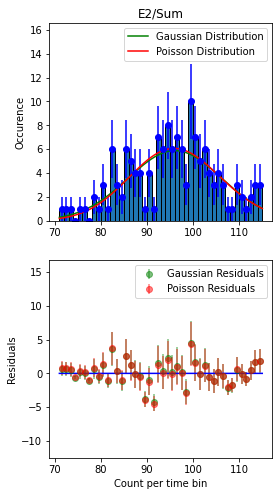

In [7]:
E2 = []
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(1), skip_header=1))
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(3), skip_header=1))
E2.append(np.genfromtxt("E2.csv", delimiter=",", usecols=(5), skip_header=1))
E2_sum=E2[0]+E2[1]+E2[2]
E2.append(E2_sum)
j=0
list_run_num=['R1','R2','R3','Sum']
E2gaverage=[]
E2paverage=[]
for x in E2:
    run_num=list_run_num[j]
    j=j+1
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[31,50,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[31,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    if(j<4):
        E2gaverage.append(unc.ufloat(gpopt[0],gperr[0]))
        E2paverage.append(unc.ufloat(ppopt[0],pperr[0]))
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E2/'+run_num)
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E2/'+run_num)

Gaussian Fit
Mean: 1.8336183429935184 +/- 0.2700214519375194
Std: 1.4187082222069678 +/- 0.28357521085055754
--------------------------------------------------
Poisson Fit
Mean: 2.0995112133292473 +/- 0.12601571802248646
Gaussian Fit
Mean: 1.832597559610387 +/- 0.18384438760421593
Std: 1.3902977591781387 +/- 0.164599509015263
--------------------------------------------------
Poisson Fit
Mean: 2.0290604145612936 +/- 0.09324009597668227
Gaussian Fit
Mean: 1.8976383916342756 +/- 0.19304233754402278
Std: 1.3785549305749973 +/- 0.19883471451404477
--------------------------------------------------
Poisson Fit
Mean: 2.1320966236499626 +/- 0.11511014682082997
Gaussian Fit
Mean: 1.9022427467943017 +/- 0.1718275620179802
Std: 1.3552715045437105 +/- 0.17371031892219793
--------------------------------------------------
Poisson Fit
Mean: 2.124551039739232 +/- 0.11839377218857479
Gaussian Fit
Mean: 1.859421967463347 +/- 0.13815596335602176
Std: 1.4057022860636885 +/- 0.11526100008580321
---------

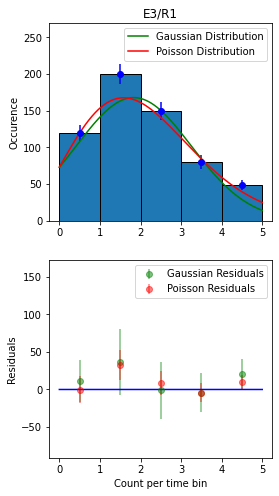

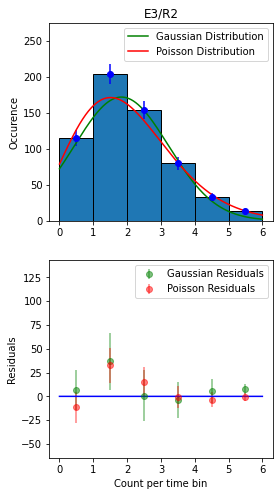

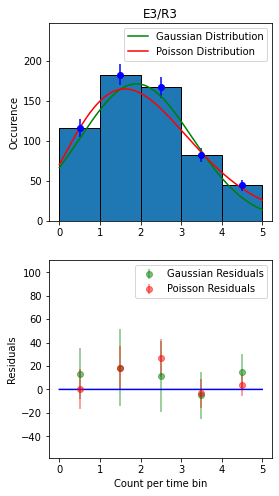

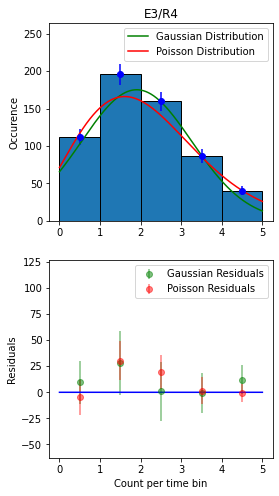

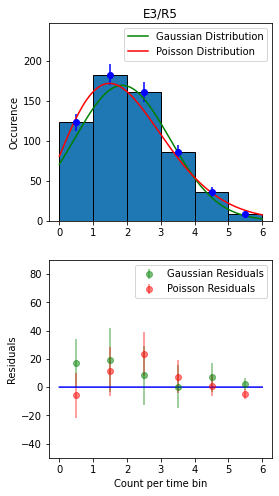

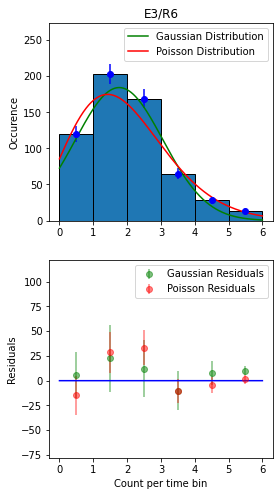

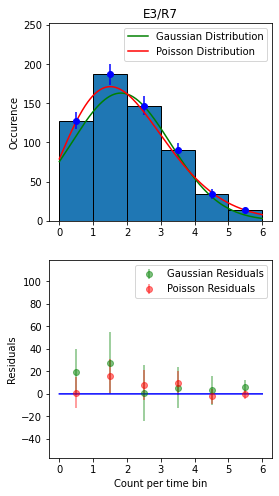

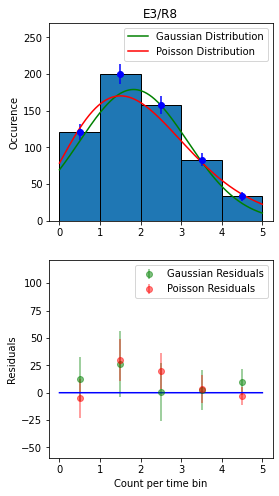

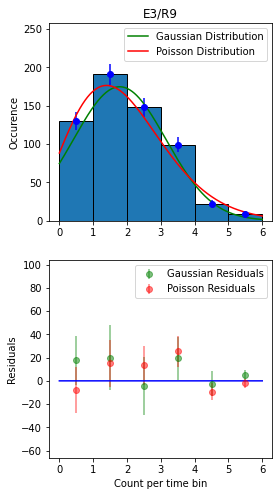

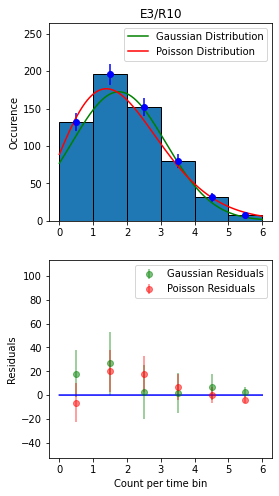

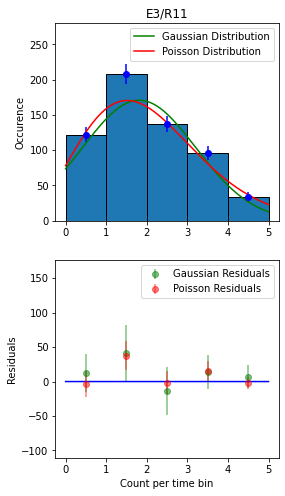

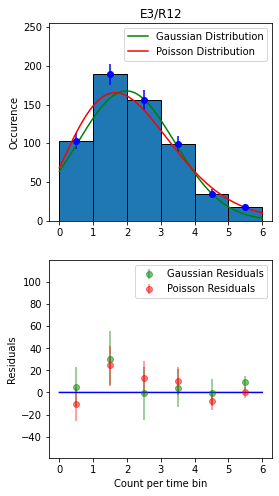

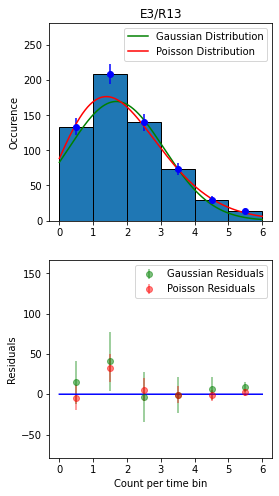

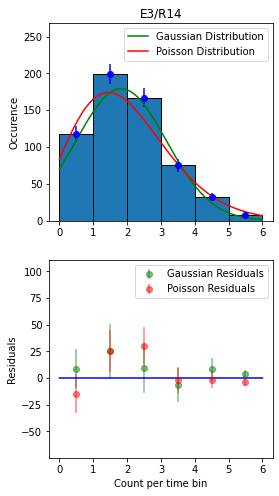

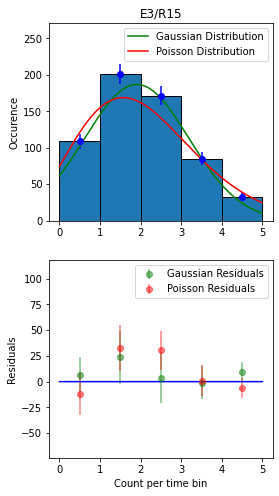

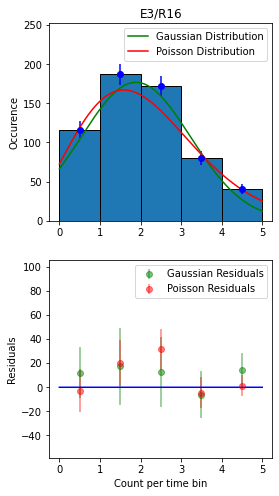

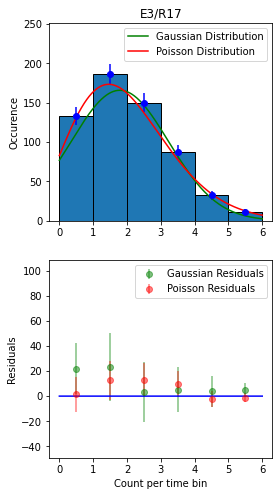

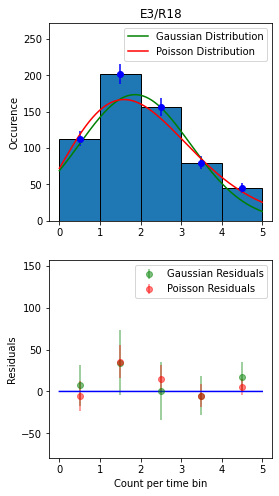

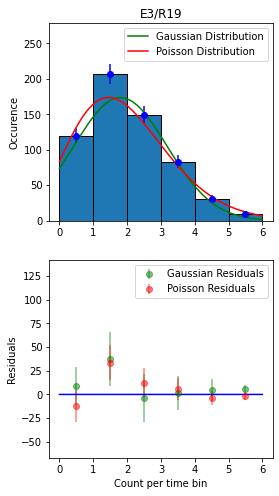

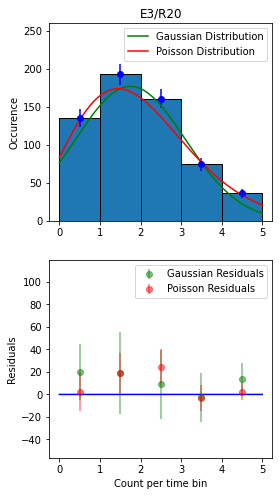

In [8]:
E3 = []
for i in range(1,41,2):
    E3.append(np.genfromtxt("E3.csv", delimiter=",", usecols=(i), skip_header=1))
h_sum=E3[0]+E3[1]+E3[2]+E3[3]+E3[4]+E3[5]+E3[6]+E3[7]+E3[8]+E3[9]+E3[10]+E3[11]+E3[12]+E3[13]+E3[14]+E3[15]+E3[16]+E3[17]+E3[18]+E3[19]
v_sum=np.array([])
for k in np.arange(0,20,1):
    v_sum = np.append(v_sum,sum(E3[k]))
j=0
list_run_num=['R1','R2','R3','R4','R5','R6','R7','R8','R9','R10','R11','R12','R13','R14','R15','R16','R17','R18','R19','R20','Horizontal Sum', 'Vertical Sum']
E3gaverage=[]
E3paverage=[]
for x in E3:
    run_num=list_run_num[j]
    j=j+1
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[2.5,2,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)),sigma=nerr)
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[2.5,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)),sigma=nerr)
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    E3gaverage.append(unc.ufloat(gpopt[0],gperr[0]))
    E3paverage.append(unc.ufloat(ppopt[0],pperr[0]))
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E3/'+run_num)
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E3/'+run_num)

Gaussian Fit
Mean: 31.63951600105831 +/- 0.2433614825301966
Std: 5.465935526962091 +/- 0.24429916820269232
--------------------------------------------------
Poisson Fit
Mean: 31.89776642419509 +/- 0.24307874932049908


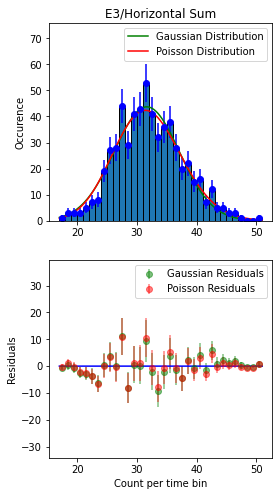

In [9]:
for x in [h_sum]:
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[35,5,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[35,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E3/Horizontal Sum')
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E3/Horizontal Sum')


Gaussian Fit
Mean: 933.2047105193049 +/- 44143027.1316639
Std: 1.5825078110258748 +/- 7351710.409642723
--------------------------------------------------


C:\Users\cadot\AppData\Local\Temp/ipykernel_23580/2749659550.py:6: RuntimeWarning: overflow encountered in power
  return A*(mu**x/scipy.special.factorial(x)) * np.exp(-mu)
C:\Users\cadot\AppData\Local\Temp/ipykernel_23580/2749659550.py:6: RuntimeWarning: invalid value encountered in true_divide
  return A*(mu**x/scipy.special.factorial(x)) * np.exp(-mu)


ValueError: Residuals are not finite in the initial point.

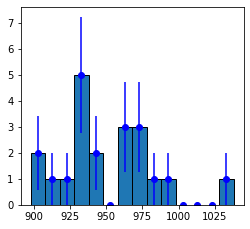

In [10]:
for x in [v_sum]:
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x)+10,10))
    x = np.linspace(min(bins)+5,max(bins)-5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[950,25,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[933,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E3/Vertical Sum')
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E3/Vertical Sum')


Gaussian Fit
Mean: 7.102521309675786 +/- 0.8685887080305954
Std: 2.71907722039778 +/- 0.6312542978057206
--------------------------------------------------
Poisson Fit
Mean: 7.036409729818368 +/- 0.5288002993832329
Gaussian Fit
Mean: 6.519623008521189 +/- 0.19402068623804666
Std: 2.3114177219409617 +/- 0.17428689772223047
--------------------------------------------------
Poisson Fit
Mean: 6.75265394320858 +/- 0.21426299932073842
Gaussian Fit
Mean: 6.7759419290164935 +/- 0.23798712553731313
Std: 2.744179564035719 +/- 0.22288167788620583
--------------------------------------------------
Poisson Fit
Mean: 6.9357531227940346 +/- 0.2327334287660811
Gaussian Fit
Mean: 6.542152579612792 +/- 0.11523818400406437
Std: 2.39772163150947 +/- 0.09706304819631331
--------------------------------------------------
Poisson Fit
Mean: 6.741383380421328 +/- 0.1347717101913922
Gaussian Fit
Mean: 6.274044560749429 +/- 0.3753768113867532
Std: 2.4548313824085404 +/- 0.297799191401387
-----------------------

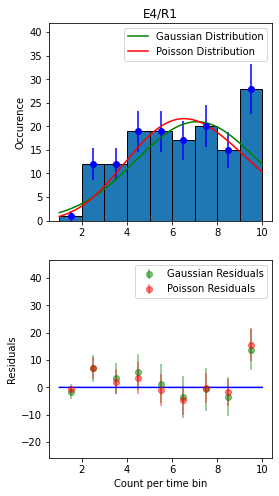

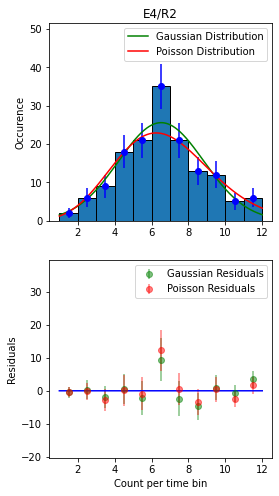

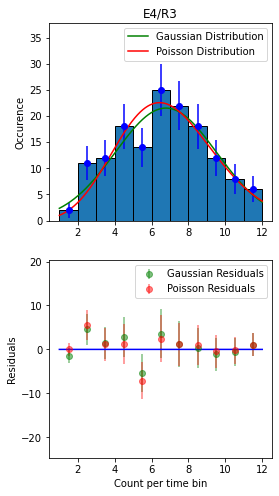

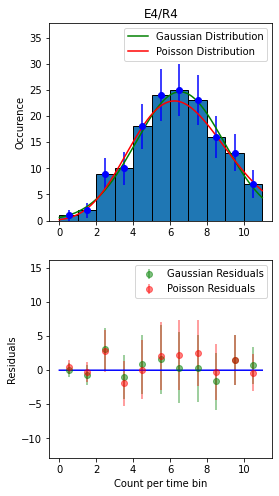

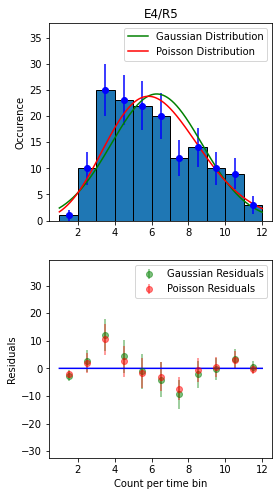

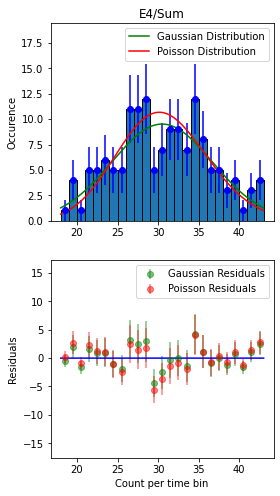

In [12]:
E4 = []
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(1), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(3), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(5), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(7), skip_header=1))
E4.append(np.genfromtxt("E4.csv", delimiter=",", usecols=(9), skip_header=1))
E4_sum=E4[0]+E4[1]+E4[2]+E4[3]+E4[4]
E4.append(E4_sum)
j=0
list_run_num=['R1','R2','R3','R4','R5','Sum']
E4gaverage=[]
E4paverage=[]
for x in E4:
    run_num=list_run_num[j]
    j=j+1
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[6.1,6,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)),sigma=nerr)
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[4,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)),sigma=nerr)
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    if(j<6):
        E4gaverage.append(unc.ufloat(gpopt[0],gperr[0]))
        E4paverage.append(unc.ufloat(ppopt[0],pperr[0]))
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('E4/'+run_num)
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('E4/'+run_num)

27001
Gaussian Fit
Mean: 2.160203661079547 +/- 0.06025967840061532
Std: 1.4149883617441468 +/- 0.06667837927858854
--------------------------------------------------
Poisson Fit
Mean: 2.422962175863618 +/- 0.07890092504795598
13500
Gaussian Fit
Mean: 4.166178882969273 +/- 0.06578946527077612
Std: 1.950166863987847 +/- 0.06745466406939268
--------------------------------------------------
Poisson Fit
Mean: 4.415954420569973 +/- 0.06081927643692514
5400
Gaussian Fit
Mean: 10.110671508542476 +/- 0.07350622036845438
Std: 3.110127806720155 +/- 0.07361363036303994
--------------------------------------------------
Poisson Fit
Mean: 10.35162438008257 +/- 0.06562453599736681
1350
Gaussian Fit
Mean: 39.5538102270258 +/- 0.1397016111770376
Std: 6.135336176687085 +/- 0.13993877222466825
--------------------------------------------------
Poisson Fit
Mean: 39.79344012961822 +/- 0.14441514637322148


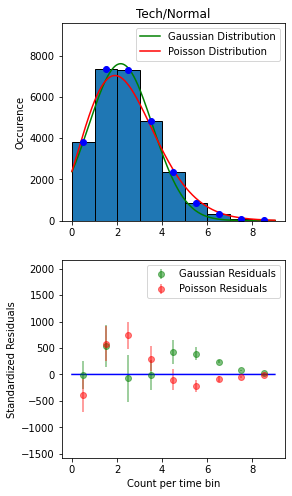

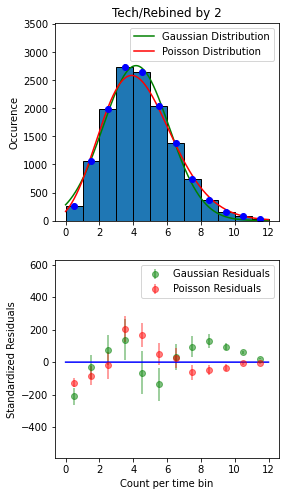

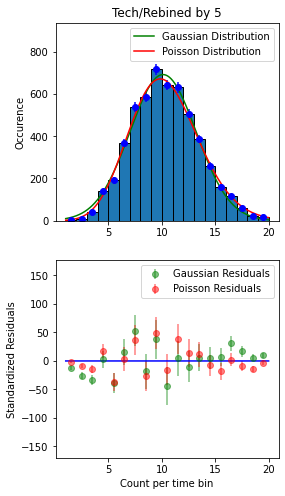

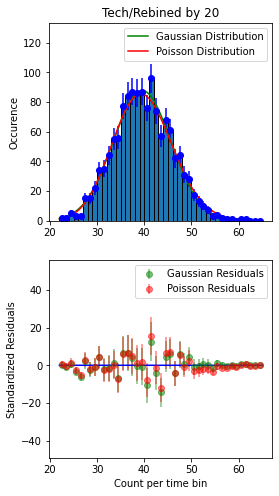

In [ ]:
Tech = []
Tech.append(np.genfromtxt("tech.csv", delimiter=",", usecols=(1), skip_header=0))
bin2 = np.array([])
for i in np.arange(0,len(Tech[0])-1,2):
    bin2=np.append(bin2,Tech[0][i]+Tech[0][i+1])
Tech.append(bin2)
bin5 = np.array([])
for i in np.arange(0,len(Tech[0])-1,5):
    bin5=np.append(bin5,Tech[0][i]+Tech[0][i+1]+Tech[0][i+2]+Tech[0][i+3]+Tech[0][i+4])
Tech.append(bin5)
bin20 = np.array([])
for i in np.arange(0,len(Tech[0])-1,20):
    _sum=0
    for j in np.arange(0,20,1):
        _sum+=Tech[0][i+j]
    bin20=np.append(bin20,_sum)
Tech.append(bin20)
j=0
list_run_num=['Normal','Rebined by 2','Rebined by 5','Rebined by 20']

for x in Tech:
    print(len(x))
    run_num=list_run_num[j]
    j=j+1
    plt.figure(figsize=(4, 8))
    plt.subplot(2,1,1)
    n,bins,patches = plt.hist(x, density=False, edgecolor='black', bins = np.arange(min(x),max(x),1))
    x = np.linspace(min(bins)+0.5,max(bins)-0.5,len(n))
    nerr=n**0.5
    norm=sum(n)
    plt.errorbar(x,n,yerr=nerr,fmt='ob')
    popt,pcov = optimize.curve_fit(Gaussian,xdata=x, ydata=n,p0=[10,6,norm],bounds=((-np.inf,-np.inf,norm-0.0001), (np.inf,np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Gaussian Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('Std: '+str(popt[1])+' +/- '+str(perr[1]))
    print('-'*50)
    gpopt=popt
    gperr=perr
    if j==4:popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[40,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    else: popt,pcov = optimize.curve_fit(Poisson,xdata=x, ydata=n, p0=[7,norm],bounds=((-np.inf,norm-0.0001), (np.inf,norm)))
    perr = np.sqrt(np.diag(pcov))
    print("Poisson Fit")
    print('Mean: '+str(popt[0])+' +/- '+str(perr[0]))
    print('='*50)
    ppopt=popt
    pperr=perr
    xs = np.linspace(min(bins),max(bins),2000)
    plt.plot(xs,Gaussian(xs,gpopt[0],gpopt[1],gpopt[2]),color='g',label='Gaussian Distribution')
    plt.plot(xs,Poisson(xs,ppopt[0],ppopt[1]),color='r',label='Poisson Distribution')
    gaussian_point=uGaussian(x,unc.ufloat(gpopt[0],gperr[0]),unc.ufloat(gpopt[1],gperr[1]),unc.ufloat(gpopt[2],gperr[2]))
    poisson_point=uPoisson(x,unc.ufloat(ppopt[0],pperr[0]),unc.ufloat(ppopt[1],pperr[1]))
    plt.legend(loc='upper right')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 1.2, ymax * 1.2)
    plt.ylabel('Occurence')
    plt.title('Tech/'+run_num)
    plt.subplot(2,1,2)
    u_n=[]
    for i in np.linspace(0,len(n)-1,len(n)):
        i=int(i)
        u_n.append(unc.ufloat(n[i],nerr[i]))
    plt.errorbar(x, unumpy.nominal_values(u_n-gaussian_point),yerr=unumpy.std_devs(u_n-gaussian_point) ,fmt='go', alpha=0.5 ,label = "Gaussian Residuals")
    plt.errorbar(x, unumpy.nominal_values(u_n-poisson_point),yerr=unumpy.std_devs(u_n-poisson_point) ,fmt='ro', alpha=0.5 ,label = "Poisson Residuals")
    plt.plot(xs,[0]*xs,'b')
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin * 2, ymax * 2)
    plt.xlabel('Count per time bin')
    plt.ylabel('Residuals')
    plt.legend()
    plt.show
    plt.savefig('Tech/'+run_num)

[3.3656263519945506+/-0.08357801273762602, 31.781331240634554+/-0.2657305483017355, 1.8241314609333958+/-0.06717296696799023, 6.786320321238744+/-0.3511632716985326]
[3.636202542033218+/-0.07316922221971471, 32.074235757878476+/-0.2709216139930103, 2.0334692287921383+/-0.08120618946057435, 6.802172283650099+/-0.2719764317738409]


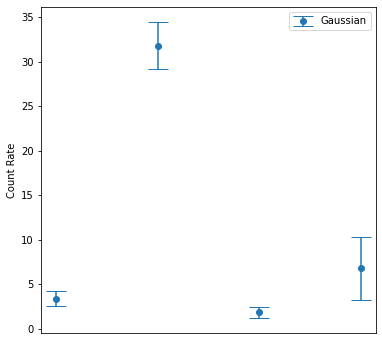

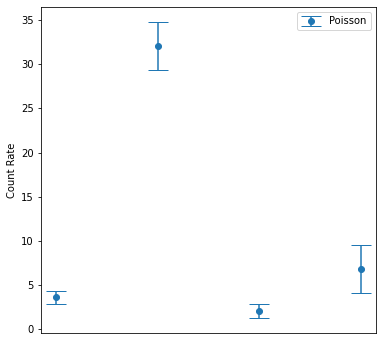

In [14]:
gaverage=[]
paverage=[]
for run in [E1gaverage,E2gaverage,E3gaverage,E4gaverage]:
    wmean = (np.average( unumpy.nominal_values(run), weights = unumpy.std_devs(run) ))
    werror = ((1/(len(run) - 1) * sum ( (unumpy.nominal_values(run)-wmean)**2) )**0.5)
    gaverage.append(unc.ufloat(wmean,werror))
for run in [E1paverage,E2paverage,E3paverage,E4paverage]:
    wmean = (np.average( unumpy.nominal_values(run), weights = unumpy.std_devs(run) ))
    werror = ((1/(len(run) - 1) * sum ( (unumpy.nominal_values(run)-wmean)**2) )**0.5)
    paverage.append(unc.ufloat(wmean,werror))
plt.plot

print(gaverage)
print(paverage)

plt.figure(figsize=(6, 6))
plt.errorbar([1,2,3,4],unumpy.nominal_values(gaverage),yerr=unumpy.std_devs(gaverage)*10,fmt='o',label='Gaussian',capsize=10)
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.legend(loc='upper right')
plt.ylabel('Count Rate')
plt.savefig('Results gaussian')
plt.show()

plt.figure(figsize=(6, 6))
plt.errorbar([1,2,3,4],unumpy.nominal_values(paverage),yerr=unumpy.std_devs(paverage)*10,fmt='o',label='Poisson',capsize=10)
figure = plt.gca()
x_axis = figure.axes.get_xaxis()
x_axis.set_visible(False)
plt.legend(loc='upper right')
plt.ylabel('Count Rate')
plt.savefig('Results poisson')
plt.show()
